Fit some of the rotation curves from SV3 using the rotation curve parameterization

\begin{equation}
  V(r) = \frac{V_\text{max}r}{(R_\text{turn}^\alpha + r^\alpha)^{1/\alpha}}
\end{equation}

In [20]:
from astropy.table import Table
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u

from scipy.optimize import minimize, curve_fit

import numpy as np

import matplotlib.pyplot as plt

In [22]:
c = 3e5

q0 = 0.2

In [4]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

In [5]:
tfuji = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')

# Compute observed velocities

In [36]:
sga_id = 1191523

sga_idx = np.argwhere(SGA['SGA_ID'] == sga_id)[0]

gal_idx = np.argwhere(tfuji['SGA_ID'] == sga_id)

In [37]:
gal_table = tfuji[gal_idx]

gal_table

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64[1],float64[1],float64[1],int64[1],bytes3[1],float64[1],float64[1],int64[1],float64[1],bytes63[1],bytes3[1],int64[1],float64[1],float64[1]
1070191999975427,150.270930072597,3.33110699263136,27259,sv3,0.209781676426744,6.6193311706894e-05,4,8.51128542702645,fuji/healpix/sv3/bright/272/27259/redrock-sv3-bright-27259.fits,TFT,1191523,150.2709300725971,3.331106992631362
1083386139508739,150.270930072597,3.33110699263136,27259,sv3,0.0125153895996837,2.83433601401733e-05,0,31.0850822513457,fuji/healpix/sv3/dark/272/27259/redrock-sv3-dark-27259.fits,TFT,1191523,150.2709300725971,3.331106992631362
1070191999975429,150.273297259029,3.33122136257727,27259,sv3,-0.00199569129234795,4.13114935733491e-48,1570,1.94266889222573e+84,fuji/healpix/sv3/bright/272/27259/redrock-sv3-bright-27259.fits,TFT,1191523,150.2732972590286,3.3312213625772693
1083386139508741,150.273297259029,3.33122136257727,27259,sv3,1.11232820233934,0.000144910501991564,4,1.48022571206093,fuji/healpix/sv3/dark/272/27259/redrock-sv3-dark-27259.fits,TFT,1191523,150.2732972590286,3.3312213625772693
1070191999975425,150.267396959543,3.33093628066686,27259,sv3,0.293597906858226,0.000175356675841198,4,3.57337550446391,fuji/healpix/sv3/bright/272/27259/redrock-sv3-bright-27259.fits,TFT,1191523,150.26739695954342,3.3309362806668634
39627865762825599,150.269764145154,3.33105065908018,27259,sv3,0.0126176769764731,7.54283735505597e-06,0,568.717685500626,fuji/healpix/sv3/bright/272/27259/redrock-sv3-bright-27259.fits,TFT,1191523,150.2697641451539,3.33105065908018
1070191999975424,150.266231032505,3.33087994294527,27259,sv3,1.17048870291897,8.21801488821356e-05,4,1.67624881863594,fuji/healpix/sv3/bright/272/27259/redrock-sv3-bright-27259.fits,TFT,1191523,150.26623103250463,3.3308799429452747
1070191999975428,150.272131331314,3.33116503182038,27259,sv3,1.09295241625378,5.19030787448517e-05,4,0.630795516073704,fuji/healpix/sv3/bright/272/27259/redrock-sv3-bright-27259.fits,TFT,1191523,150.27213133131448,3.3311650318203805
1070191999975426,150.268598217844,3.33099432415274,27259,sv3,0.0126359399037032,1.37326382644454e-05,0,84.9701145072468,fuji/healpix/sv3/bright/272/27259/redrock-sv3-bright-27259.fits,TFT,1191523,150.2685982178442,3.33099432415274


## Does this galaxy have a good central velocity?

In [16]:
def firstdigit(n):
    """
    Return the first digit of a number.
    
    Parameters
    ----------
    n : int, float, or ndarray
        Number or list of numbers.
    
    Returns
    -------
    digit : int
        First digit of the number.
    """
    
    digit = np.trunc(n * 10**(-np.trunc(np.log10(n)))).astype(int)
    
    return digit

In [38]:
first_digits = firstdigit(gal_table['TARGETID'])

gal_centers = gal_table[first_digits == 3]
gal_axis = gal_table[first_digits != 3]

### Set the central velocity of the galaxy

Only use those with
 * DELTACHI2 > 25
 * ZWARN == 0

In [39]:
good_centers = gal_centers[(gal_centers['DELTACHI2'] > 25) & (gal_centers['ZWARN'] == 0)]

## Calculate the rotational velocities

In [40]:
#---------------------------------------------------------------------------
# Calculate distance between each observation and the center
#---------------------------------------------------------------------------
center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                         dec=SGA['DEC'][sga_idx], 
                         unit=u.degree)
target_coords = SkyCoord(ra=gal_axis['RA'], 
                         dec=gal_axis['DEC'], 
                         unit=u.degree)

sep2d = target_coords.separation(center_coords)

gal_axis['SKY_FIBER_DIST'] = sep2d
gal_axis['SKY_FIBER_DIST_R26'] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
#---------------------------------------------------------------------------


#---------------------------------------------------------------------------
# Calculate rotational velocity
#---------------------------------------------------------------------------
# Use the average redshift of all center observations for the systemic velocity
z_center = np.mean(good_centers['Z'])
z_err_center2 = good_centers['ZERR']**2

# Calculate rotational velocity for all observations of the galaxy
gal_axis['V_ROT'] = c*(gal_axis['Z'] - z_center)
gal_axis['V_ROT_ERR'] = c*np.sqrt(gal_axis['ZERR']**2 + z_err_center2)
#---------------------------------------------------------------------------


#---------------------------------------------------------------------------
# Correct rotational velocities for inclination angle
#---------------------------------------------------------------------------
cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)

# Galaxies with b/a < q0
if cosi2 < 0:
    cosi2 = 0

gal_axis['V_ROT'] /= np.sin(np.arccos(np.sqrt(cosi2)))
#---------------------------------------------------------------------------

# Rotation curve functions

From `dark_matter_mass_v1.py`

In [6]:
def rot_fit_BB( depro_radius, params):
    """
    Function to fit the rotation curve data to.


    PARAMETERS
    ==========
    
    depro_radius : float or ndarray of shape (n,)
        Deprojected radius as taken from the [PLATE]-[FIBERID] rotation curve 
        data file (in units of kpc); the "x" data of the rotation curve equation

    v_max : float
        The maximum velocity (or in the case of fitting the negative, the
        absolute value of the minimum velocity) parameter of the rotation curve 
        equation (given in km/s)

    r_turn : float
        The radius at which the rotation curve trasitions from increasing to 
        flat-body for the rotation curve equation (given in kpc)

    alpha : float
        The exponential parameter for the rotation curve equation


    RETURNS
    =======
        
    The rotation curve equation with the given '@param' parameters and
    'depro_radius' data
    """

    v_max, r_turn, alpha = params

    v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))

    v = v*np.sign(depro_radius)

    return v


def logL_BB(params, r, v, v_err):
    '''
    Log likelihood of the data and the fit values for the BB fit function.


    PARAMETERS
    ==========

    params : list or ndarray
        List of 3 fit parameters

    r : ndarray
        Radius values for the data points

    v : ndarray
        Velocity values for the data points

    v_err : ndarray
        Velocity error values for the data points


    RETURNS
    =======

    logL : float
        Log likelihood of set velocity given model parameters
    '''

    lambda1 = rot_fit_BB(r, params)
    lambda1[lambda1 <= 0] = np.finfo( dtype=np.float64).tiny

    return np.sum( ((v - lambda1)/v_err)**2 + np.log(2*np.pi*np.array(v_err)**2))


def nlogL_BB(params, radius, velocity, velocity_err):
    '''
    Negative log likelihood, for minimizing.
    '''
    return -logL_BB(params, radius, velocity, velocity_err)


def chi2_BB(params, radius, velocity, velocity_err):
    '''
    chi2 of the rotation curve approximation


    PARAMETERS
    ==========

    params : list
        List of fit parameters

    radius : ndarray
        Radius values for the data points

    velocity : ndarray
        Velocity values for the data points

    velocity_err : ndarray
        Velocity uncertainty values for the data points


    RETURNS
    =======

    chi2_norm : float
        Chi2 value of the current value of the params normalized by the number 
        of data points (minus the number of free parameters)
    '''

    ############################################################################
    # Create fitted rotation curve based on the values in params
    #---------------------------------------------------------------------------
    vel_model = rot_fit_BB(radius, params)
    ############################################################################


    ############################################################################
    # Calculate chi2 of current fit
    #---------------------------------------------------------------------------
    chi2 = np.sum((vel_model - velocity)**2 / velocity_err**2)

    chi2_norm = chi2/(len(radius) - len(params))
    ############################################################################


    return chi2_norm

# Fit rotation curve

In [41]:
gal_axis[['TARGETID', 'SKY_FIBER_DIST_R26', 'Z', 'V_ROT', 'V_ROT_ERR', 'ZWARN', 'DELTACHI2']]

TARGETID,SKY_FIBER_DIST_R26,Z,V_ROT,V_ROT_ERR,ZWARN,DELTACHI2
,,,,,,
int64,float64,float64,float64,float64,int64,float64
1070191999975427,0.3299999935897836,0.209781676426744,80117.42176079963,19.98650549516291,4,8.51128542702645
1083386139508739,0.3299999935897836,0.0125153895996837,-41.56438766656845,8.798956832831681,0,31.0850822513457
1070191999975429,0.9999999805612407,-0.00199569129234795,-5938.12963930223,2.262851206516791,1570,1.94266889222573e+84
1083386139508741,0.9999999805612407,1.11232820233934,446866.4270401432,43.532003382030005,4,1.48022571206093
1070191999975425,0.6699999869753633,0.293597906858226,114176.07497640919,52.65564769490149,4,3.57337550446391
1070191999975424,0.9999999805557612,1.17048870291897,470499.8964754836,24.757673838810703,4,1.67624881863594
1070191999975428,0.6699999869752118,1.09295241625378,438993.09301318065,15.734489444221547,4,0.630795516073704
1070191999975426,0.32999999358295595,0.0126359399037032,7.421124787285228,4.700338010826923,0,84.9701145072468


In [26]:
# R_turn
r_turn_guess = 0.5 # R(26)
r_turn_low = 0.001 # R(26)
r_turn_high = 2.   # R(26)
r_turn_bounds = (r_turn_low, r_turn_high)

# Vmax
v_max_guess = np.max(np.abs(gal_table['V_ROT'].data))
v_max_low = 1.0    # km/s
v_max_high = 1000. # km/s
v_max_bounds = (v_max_low, v_max_high)

# alpha
alpha_guess = 2.
alpha_low = np.nextafter(0,1)
alpha_high = 10.
alpha_bounds = (alpha_low, alpha_high)

rot_param_bounds = [v_max_bounds, r_turn_bounds, alpha_bounds]
rot_param_low = [v_max_low, r_turn_low, alpha_low]
rot_param_high = [v_max_high, r_turn_high, alpha_high]
rot_param_guess = [v_max_guess, r_turn_guess, alpha_guess]


results = None

for i in range(30):
    p0 = [np.random.uniform(b[0], b[1]) for b in rot_param_bounds]
    result = minimize(chi2_BB, #nlogL_BB, 
                      p0, 
                      method='Powell',#'L-BFGS-B',
                      args=(gal_table['RADIUS'], np.abs(gal_table['V_ROT'].data), np.abs(gal_table['V_ROT_ERR'].data)), 
                      bounds=rot_param_bounds)
    if result.success:
        if results is None:
            results = result
        else:
            if result.fun < results.fun:
                results = result

#rot_perr = np.sqrt(np.diag(results.hess_inv.todense()))

print(results)

None


<ipython-input-32-e7b196447618>:3: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.errorbar(gal_table['RADIUS'], np.abs(gal_table['V_ROT']), yerr=gal_table['V_ROT_ERR'], fmt='o')


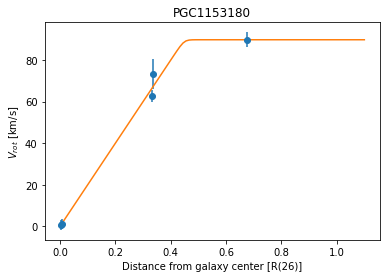

In [32]:
plt.figure()

plt.errorbar(gal_table['RADIUS'], np.abs(gal_table['V_ROT']), yerr=gal_table['V_ROT_ERR'], fmt='o')

R = np.linspace(0,1.1,100)
plt.plot(R,rot_fit_BB(R, [89.75, 0.4492, 58.66])) # Fit values from MATLAB

plt.xlabel('Distance from galaxy center [R(26)]')
plt.ylabel('$V_{rot}$ [km/s]')

plt.title(galaxy)

plt.savefig('../images/PV_fits/' + galaxy + '_fit.png', format='png', dpi=300);